In [1]:
import PIL
import os
import pandas as pd
import numpy as np
import moviepy.editor as mpy
import matplotlib.pyplot as plt
import random
from sklearn.cluster import DBSCAN, AgglomerativeClustering, MeanShift
from scipy.spatial import ConvexHull
from scipy.stats import wasserstein_distance as wdistance
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from sklearn.feature_extraction import image

from skimage.feature import hog
from skimage import data, exposure

from torchvision import models
import torch
#https://gurus.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/



In [2]:
vgg16 = models.vgg16(pretrained=True).to('cuda').eval()

In [3]:
images = []
for name in os.listdir('abstract'):
    image = PIL.Image.open(os.path.join('abstract', name))
    img = np.array(image)
    #plt.imshow(img)
    #plt.show()
    images.append(img)
images = images[4:] + images[:4]

In [4]:
def abstractImagePointOfInterests(img):
    # Based on http://stackoverflow.com/a/41850409/3293881
    def patchify(img, patch_shape): 
        X, Y, a = img.shape
        x, y = patch_shape
        shape = (X - x + 1, Y - y + 1, x, y, a)
        X_str, Y_str, a_str = img.strides
        strides = (X_str, Y_str, X_str, Y_str, a_str)
        return np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)

    def sliding_patches(a, patch_sizes_x, patch_sizes_y, patch_size):
        patches = []
        for i, x in enumerate(patch_sizes_x):
            y = patch_sizes_y[i]
            patches.append(a[x:x+patch_size, y:y+patch_size])
        return np.array(patches)
    
    def listToIntArray(a):
        a = np.array(a, dtype=np.float32)
        return a
    
    def histsToIndexes(hog_hists, std_coef=2.0, threshold=0.2):
        hog_table = pairwise_distances(hog_hists, metric = wdistance)
        hog_border = np.mean(hog_table)+np.std(hog_table)*std_coef
        unique_table = np.sum(hog_table>hog_border, axis=0)
        hog_indexes = np.where(np.sum(hog_table>hog_border, axis=0) > threshold*len(hog_table))[0]

        return hog_indexes, unique_table[hog_indexes]

    def featuresToIndexes(hog_hists, std_coef=2.0, threshold=0.2):
        hog_table = pairwise_distances(hog_hists)
        hog_border = np.mean(hog_table)+np.std(hog_table)*std_coef
        unique_table = np.sum(hog_table>hog_border, axis=0)
        hog_indexes = np.where(np.sum(hog_table>hog_border, axis=0) > threshold*len(hog_table))[0]

        return hog_indexes, unique_table[hog_indexes]
    
    patch_number = 400#int(1.5*(img.shape[0]*img.shape[1])/(patch_size*patch_size))
    patch_size=int(np.sqrt(10*img.shape[0]*img.shape[1]/patch_number))
    BSZ=patch_size

    indexes_x = np.random.uniform(0, img.shape[0]-patch_size, patch_number).astype(int)
    indexes_y = np.random.uniform(0, img.shape[1]-patch_size, patch_number).astype(int)

    patches_indexes = np.random.uniform(0, img.shape[0]*img.shape[1], patch_number).astype(int)

    out = sliding_patches(img, indexes_x, indexes_y, patch_size)
    patches = out.reshape(-1, patch_size, patch_size, 3)
    lab_patches = rgb2lab(patches)

    n_L = 100
    n_A = 100
    n_B = 100
    hog_hists = []
    lab_hists = []
    vgg_hists = []
    print(len(patches))

    for i in range(len(lab_patches)):
        hist_L = np.histogram(lab_patches[i, :, :, 0].reshape(-1).astype(float), n_L, [0,100],)[0]
        hist_A = np.histogram(lab_patches[i, :, :, 0].reshape(-1).astype(float), n_A, [-86.185, 98.254],)[0]
        hist_B = np.histogram(lab_patches[i, :, :, 0].reshape(-1).astype(float), n_B, [-107.863, 94.482],)[0]
        hist_hog, hog_image = hog(patches[i], orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, multichannel=True, feature_vector=True)
        hist_vgg = vgg16(torch.tensor(patches[i:i+1], dtype=torch.float32, device='cuda').permute(0, 3, 1, 2)).detach().cpu().numpy()[0]
        #hist_L = hist_L/np.max(hist_L)
        #hist_B = hist_B/np.max(hist_B)
        #hist_A = hist_A/np.max(hist_A)
        #print(hist_hog.shape)
        #print(np.linalg.norm(hist_hog))
        hist_hog = hist_hog#/np.linalg.norm(hist_hog)
        hist_lab = np.hstack([hist_L, hist_A, hist_B])
        hist = hist_hog#np.hstack([hist_L, hist_A, hist_B, hist_hog])
        #plt.plot(range(len(hist)), hist)
        #plt.show()
        hog_hists.append(hist_hog)
        lab_hists.append(hist_lab)
        vgg_hists.append(hist_vgg)


    hog_hists = listToIntArray(hog_hists)
    lab_hists = listToIntArray(lab_hists)
    vgg_hists = np.array(vgg_hists)
    vgg_hists = np.array(vgg_hists, dtype=float).reshape(-1,1000)
    
    vgg_indexes, vgg_table = featuresToIndexes(vgg_hists)
    hog_indexes, hog_table = histsToIndexes(hog_hists, std_coef=2.0, threshold=0.3)
    lab_indexes, lab_table = histsToIndexes(lab_hists, std_coef=2.0, threshold=0.19)
    
    inter_set = (set(np.hstack([hog_indexes,lab_indexes])))
    indexes = np.array(list(inter_set.intersection(list(set(list(vgg_indexes))))))
    
    data = [vgg_indexes, hog_indexes, lab_indexes]
    indexesc = (set(np.hstack([data[1], data[2]])))
    indexesc = data[0]#np.array(list(indexesc))
    indexesc = (set(data[0])).intersection(set(data[2]))
    indexesc = np.array(list(indexesc))
    indexesc = np.hstack([indexesc, data[1]]).astype(int)
    
    res_indexes = np.hstack([indexesc, indexes]).astype(int)
    return indexes_x, indexes_y, res_indexes, patch_size, data

def putSquares(image_input,indexes_x, indexes_y, patch_size_x, patch_size_y, confidence1=1.0, confidence2=1.0):
    from skimage import io, draw
    image = image_input.copy()
    frames = []
    shape = image.shape
    x, y = 0, 0
    for i in range(len(indexes_x)):
                x = indexes_x[i]
                y = indexes_y[i]
                w = patch_size_x
                h = patch_size_y
                #print(cur_box)
                confidence = 1
                boundingBox = [
                    [x, y],
                    [x,  y+h],
                    [x+w, y+h],
                    [x+w, y]
                ]
                # Wiggle it around to make a 3px border
                rr, cc = draw.polygon_perimeter([x[1] for x in boundingBox], [x[0] for x in boundingBox], shape= shape)
                rr2, cc2 = draw.polygon_perimeter([x[1] + 1 for x in boundingBox], [x[0] for x in boundingBox], shape= shape)
                rr3, cc3 = draw.polygon_perimeter([x[1] - 1 for x in boundingBox], [x[0] for x in boundingBox], shape= shape)
                rr4, cc4 = draw.polygon_perimeter([x[1] for x in boundingBox], [x[0] + 1 for x in boundingBox], shape= shape)
                rr5, cc5 = draw.polygon_perimeter([x[1] for x in boundingBox], [x[0] - 1 for x in boundingBox], shape= shape)
                boxColor = (int(255 * (1 - (confidence ** 2))), int(255 * (confidence ** 2)), 0)
                draw.set_color(image, (rr, cc), boxColor, alpha= 0.8)
                draw.set_color(image, (rr2, cc2), boxColor, alpha= 0.8)
                draw.set_color(image, (rr3, cc3), boxColor, alpha= 0.8)
                draw.set_color(image, (rr4, cc4), boxColor, alpha= 0.8)
                draw.set_color(image, (rr5, cc5), boxColor, alpha= 0.8)
    return image


400


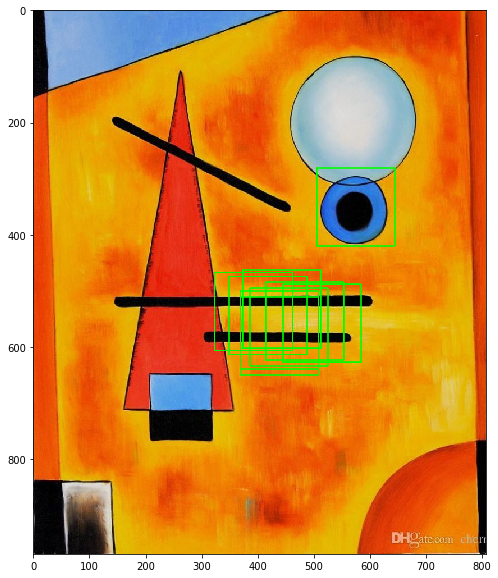

400


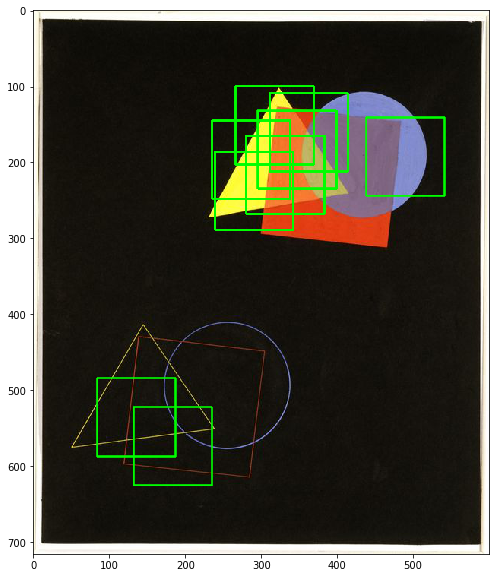

400


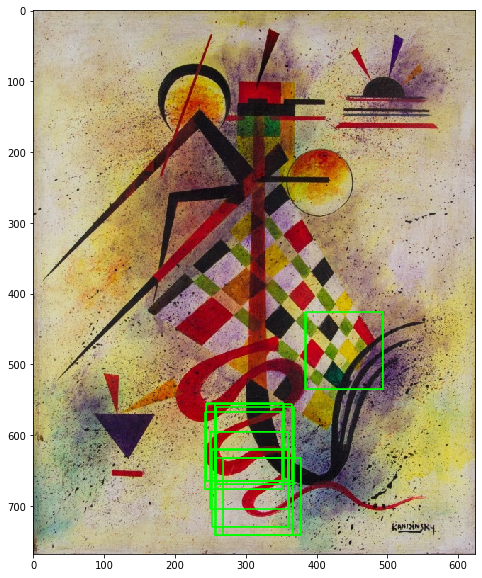

400


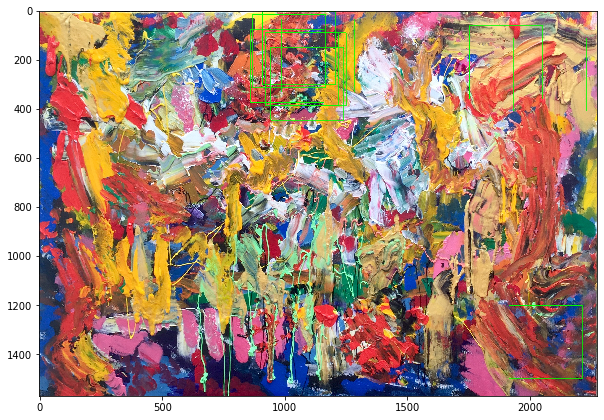

400


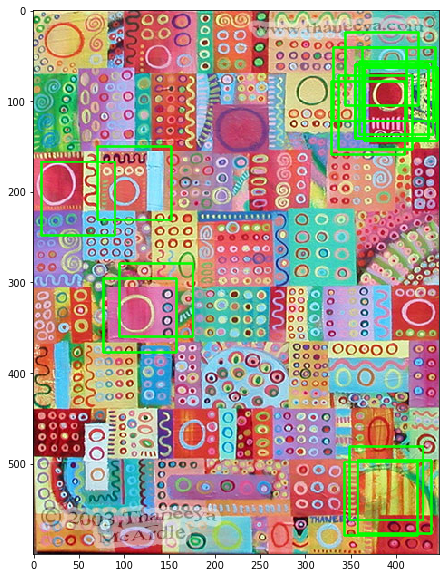

400


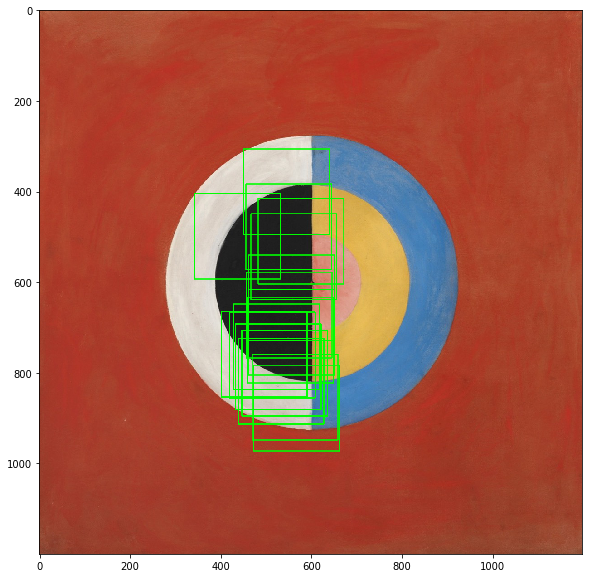

400


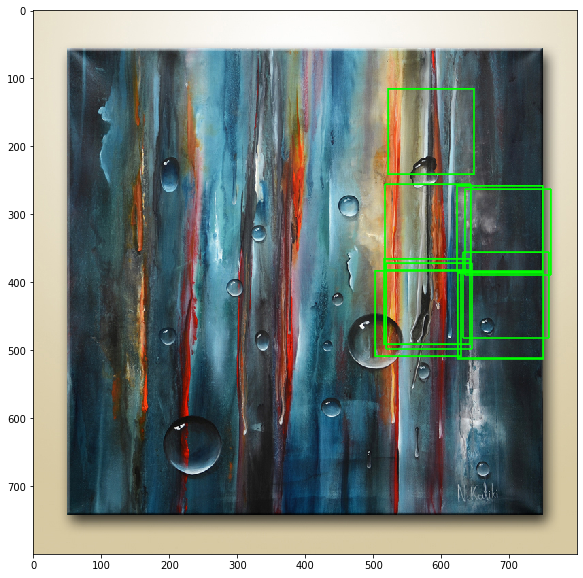

400


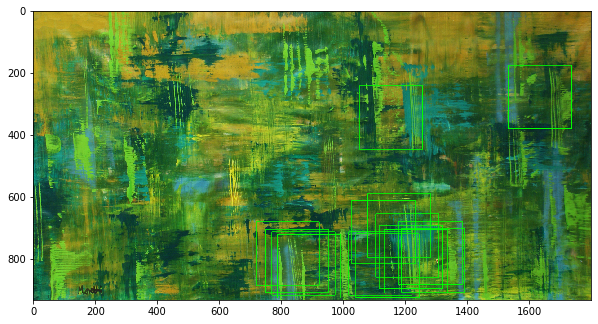

400


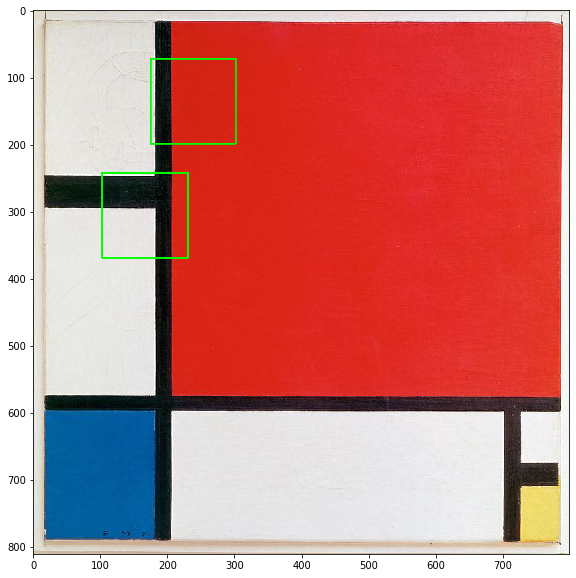

400


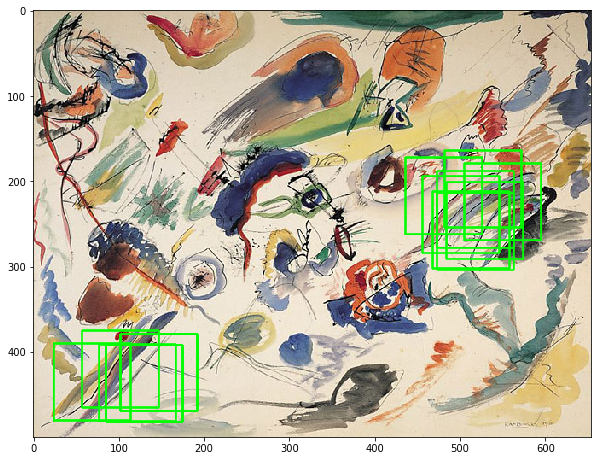

400


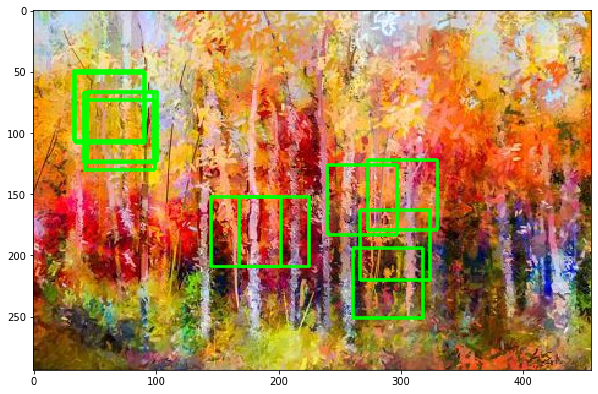

In [5]:
for i in range(11):
    img = images[i]
    indexes_x, indexes_y, indexes, patch_size, data = abstractImagePointOfInterests(img)
    if len(indexes) != 0:
        im = putSquares(img,indexes_y[indexes], indexes_x[indexes], patch_size, patch_size)
        plt.figure(figsize=(10,10))
        plt.imshow(im)
        plt.show()
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.show()
    #indexesc = (set(np.hstack([data[1], data[2]])))
    #indexesc = data[0]#np.array(list(indexesc))
    #indexesc = (set(data[0])).intersection(set(data[2]))
    #indexesc = np.array(list(indexesc))
    #indexesc = np.hstack([indexesc, data[1]]).astype(int)
    #if len(indexesc) != 0 and len(indexes) != 0:
    #    im = putSquares(img,indexes_y[indexesc], indexes_x[indexesc], patch_size, patch_size)
    #    plt.figure(figsize=(10,10))
    #    plt.imshow(im)
    #    plt.show()

Old:

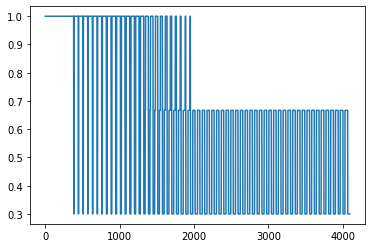

1.0
0.8
1.0
-0.96875


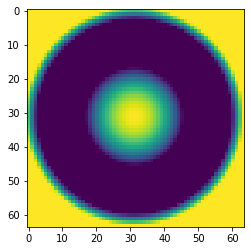

In [202]:
import math
s = []
d = 1.0/9
tus = []
field = np.zeros((64, 64))
for y in range(64):
    for x in range(64):
        tu = (y - 31)/32
        tus.append(tu)
        tv = (x - 31)/32
        v = math.atan2(tu,tv)/math.pi
        v = v
        
        #if v > 1 - 9*d:
        #    v = 3.0/3
        if (v>=1.0/3+d):
            v = 2.0/3
        if (v<-1.0+d):
            v = 2.0/3
        if (v<-1.0/3+d):
            v = 3.0/3

        #v = abs(v)
        if v <= 1.0/3+d:
            v = 0.3
        
        s.append(v)
        p = tu*tu+tv*tv
        if p >= 1:
            field[y,x]=1
            continue
        v1 = (1 - p)
        v2 = p
        threshold = 0.8
        v1 = v1 * (v1>=threshold) 
        
        v2 = v2 * (v2>=threshold) 
        v3 = (v2<=threshold and v1<=threshold)  * threshold
        field[y,x]=v1*1+v2*1+v3*1
        if field[y,x] > 1:
            field[y,x] = 0.5
        
        tus.append(v2)
plt.plot(range(len(s)), s)
plt.show()
plt.imshow(field)
print(np.max(field))
print(np.min(field))
print(max(tus))
print(min(tus))